## Install Dependency

In [ ]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=e7ced5d0dc725d06bb79a383f1461cf0202ada59bb01fabd731e03cb9fabbf42
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
Successfully built pyswarm


## Import Library

In [ ]:
# File dan OS Utilities
import os
import shutil
import random
import time
import string

# Data Handling dan Analisis
import numpy as np
from sklearn.model_selection import train_test_split

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from scipy.ndimage import gaussian_filter1d

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# PyTorch - Vision dan Augmentasi
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF

# Image Processing
from PIL import Image, ImageEnhance
import cv2

# Library PSO
from pyswarm import pso

# Progress Bar
from tqdm import tqdm
import itertools
import builtins

In [ ]:
import sys

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", seaborn.__version__)
print("numpy:", numpy.__version__)
print("Pillow:", PIL.__version__)
print("pyswarm:", pyswarm.__version__)
print("CV:", cv2.__version__)
print("python:", sys.version)

torch: 2.6.0+cu124
torchvision: 0.21.0+cu124


NameError: name 'sklearn' is not defined

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/brain tumor data/brain_tumor_dataset"

# Cek subfolder
print("Subfolder dalam dataset:", os.listdir(dataset_path))

# Jumlah gambar di setiap kelas
no_images = len(os.listdir(os.path.join(dataset_path, "no")))
yes_images = len(os.listdir(os.path.join(dataset_path, "yes")))

print(f"Jumlah gambar di kelas 'no': {no_images}")
print(f"Jumlah gambar di kelas 'yes': {yes_images}")
print(f"Jumlah total gambar dalam dataset: {no_images + yes_images}")

Subfolder dalam dataset: ['yes', 'no']
Jumlah gambar di kelas 'no': 98
Jumlah gambar di kelas 'yes': 155
Jumlah total gambar dalam dataset: 253


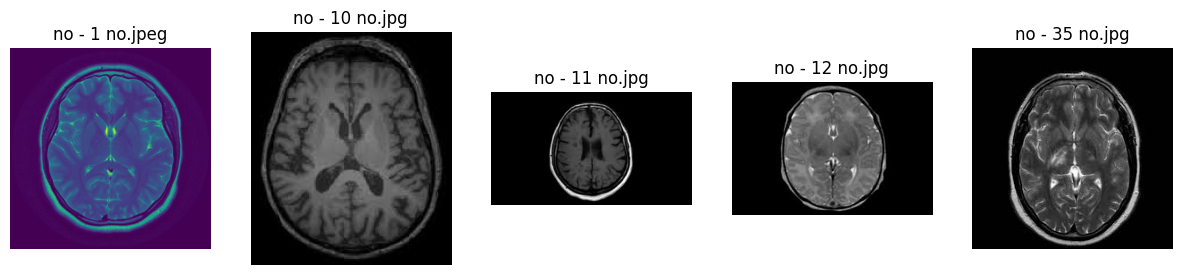

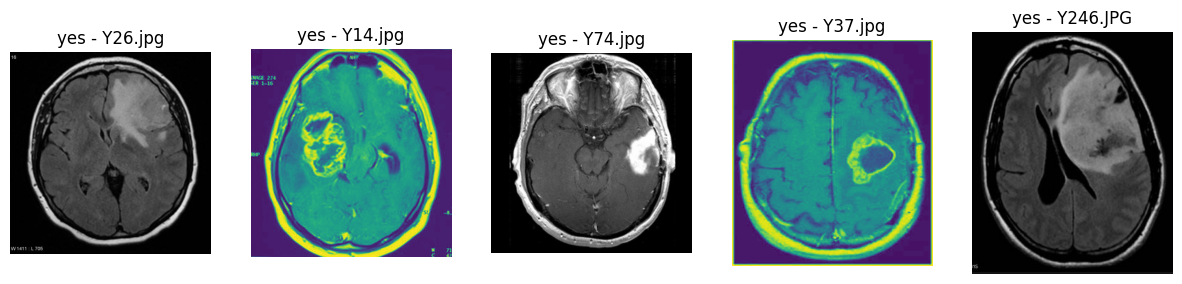

In [ ]:
# Fungsi untuk menampilkan beberapa gambar dari satu kelas
def show_images(class_name, num_images=5):
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"{class_name} - {img_file}")

    plt.show()

# Menampilkan 5 gambar dari kelas 'no' dan 'yes'
show_images("no", 5)
show_images("yes", 5)

## Preprocessing Data Tumor

### Cek Channel Gambar

In [ ]:
# Path dataset
dataset_path = "/content/drive/MyDrive/brain tumor data/brain_tumor_dataset"

# Nama kelas: 'no' and 'yes'
class_names = ["no", "yes"]

# Cek folder
for class_name in class_names:
    print("Mengecek isi folder:", class_name)

    class_folder = os.path.join(dataset_path, class_name)
    for file_name in os.listdir(class_folder):

        # Mengecek file dan memastikan file dalam bentuk jpg, jpeg, png
        if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(class_folder, file_name)

            try:
                image = Image.open(image_path)

                # Cek gambar (selain RGB yang akan ditampilkan)
                if image.mode != "RGB":
                    print("-", file_name, "-> Mode:", image.mode)

                image.close()

            except Exception as error:
                print("-", file_name, "-> Gambar tidak bisa terbuka", error)

Sedang memeriksa folder: no
- 1 no.jpeg -> Mode: L
- N15.jpg -> Mode: L
- N21.jpg -> Mode: L
- 48 no.jpeg -> Mode: L
- No13.jpg -> Mode: L
- no 10.jpg -> Mode: L
- No18.jpg -> Mode: RGBA
- N3.jpg -> Mode: L
- No15.jpg -> Mode: RGBA
- no.jpg -> Mode: RGBA
- no 98.jpg -> Mode: P
- no 5.jpeg -> Mode: L
- No21.jpg -> Mode: L
- no 4.jpg -> Mode: L
- No17.jpg -> Mode: RGBA
- no 95.jpg -> Mode: L
- no 94.jpg -> Mode: L
- no 96.jpg -> Mode: RGBA
- no 99.jpg -> Mode: L
Sedang memeriksa folder: yes
- Y14.jpg -> Mode: L
- Y37.jpg -> Mode: L
- Y70.jpg -> Mode: L
- Y24.jpg -> Mode: L
- Y10.jpg -> Mode: L
- Y54.jpg -> Mode: L
- Y62.jpg -> Mode: L
- Y52.jpg -> Mode: L
- Y12.jpg -> Mode: L
- Y101.jpg -> Mode: L
- Y31.jpg -> Mode: L
- Y17.jpg -> Mode: L
- Y39.jpg -> Mode: L
- Y41.jpg -> Mode: L
- Y38.jpg -> Mode: L
- Y92.png -> Mode: L
- Y30.jpg -> Mode: L


### ROI

In [ ]:
input_folder = "/content/drive/MyDrive/brain tumor data/brain_tumor_dataset"
output_folder = "/content/drive/MyDrive/brain tumor data/brain_tumor_dataset_roi"
os.makedirs(output_folder, exist_ok=True)

class_names = ["no", "yes"]

def load_as_gray(img_path):
    try:
        with Image.open(img_path) as img:
            gray_img = img.convert("L")
            return np.array(gray_img)
    except Exception as e:
        print(f"Error membaca gambar: {img_path} - {e}")
        return None

def crop_by_extreme_points(gray_img):
    contours, _ = cv2.findContours(gray_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    c = max(contours, key=cv2.contourArea)
    topmost = tuple(c[c[:, :, 1].argmin()][0])
    bottommost = tuple(c[c[:, :, 1].argmax()][0])
    leftmost = tuple(c[c[:, :, 0].argmin()][0])
    rightmost = tuple(c[c[:, :, 0].argmax()][0])
    x_min, x_max = leftmost[0], rightmost[0]
    y_min, y_max = topmost[1], bottommost[1]
    return gray_img[y_min:y_max, x_min:x_max]

for class_name in class_names:
    input_dir = os.path.join(input_folder, class_name)
    output_dir = os.path.join(output_folder, class_name)
    os.makedirs(output_dir, exist_ok=True)

    for fname in tqdm(os.listdir(input_dir), desc=f"Processing {class_name}"):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img_path = os.path.join(input_dir, fname)
        gray_img = load_as_gray(img_path)
        if gray_img is None:
            continue
        roi = crop_by_extreme_points(gray_img)
        if roi is not None:
            save_path = os.path.join(output_dir, fname)
            cv2.imwrite(save_path, roi)
        else:
            print(f"Skipping {fname} (no ROI found)")

Processing yes: 100%|██████████| 155/155 [00:06<00:00, 23.14it/s]


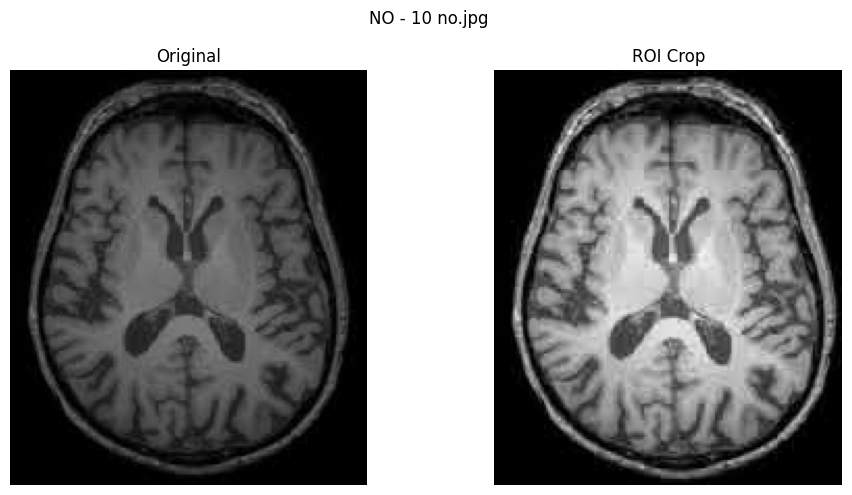

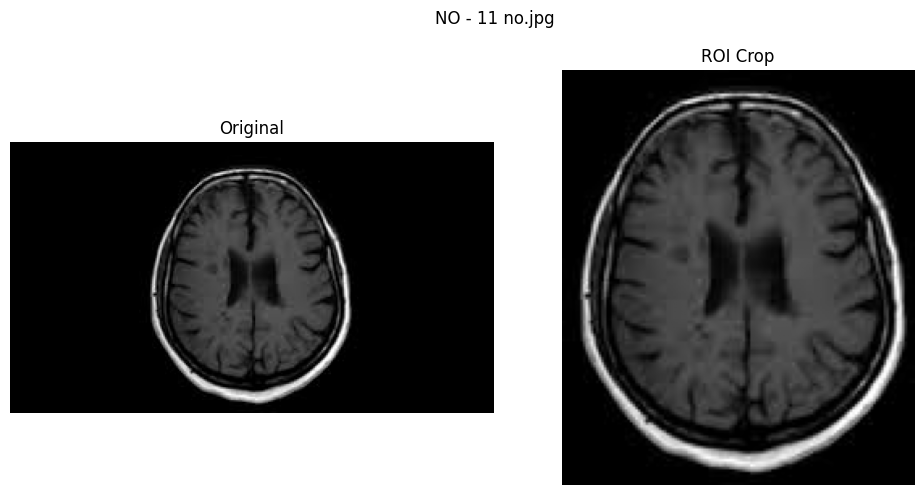

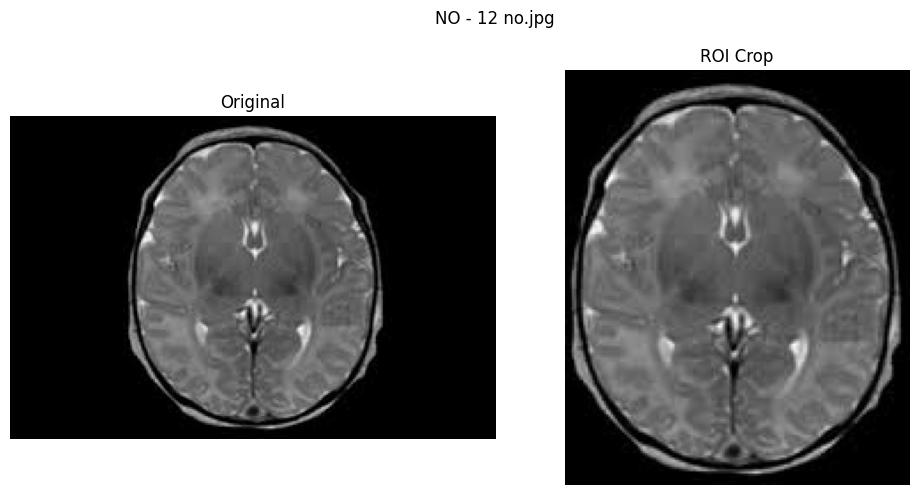

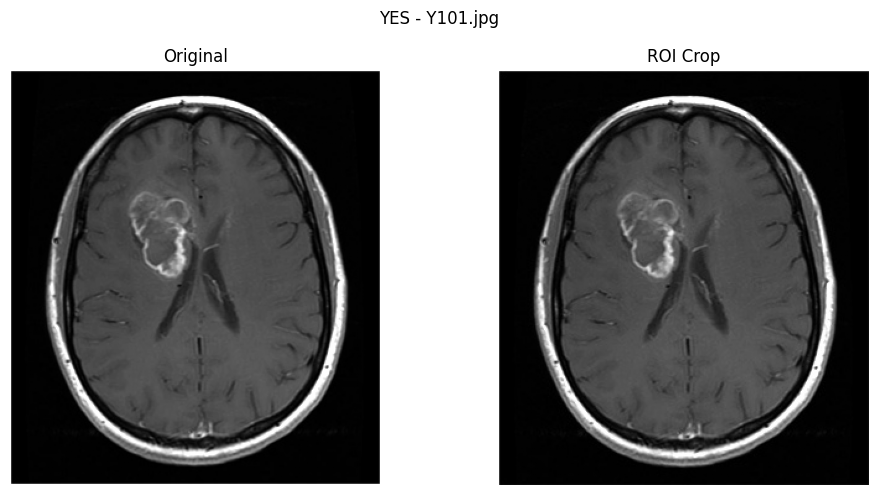

In [ ]:
# Path asli dan hasil ROI
original_base = "/content/drive/MyDrive/brain tumor data/brain_tumor_dataset"
roi_base = "/content/drive/MyDrive/brain tumor data/brain_tumor_dataset_roi"

# Konfigurasi
class_names = ["no", "yes"]
num_images = 5  # jumlah gambar per kelas yang ingin ditampilkan

for class_name in class_names:
    original_dir = os.path.join(original_base, class_name)
    roi_dir = os.path.join(roi_base, class_name)

    # Mengambil hanya file gambar .jpg/.png
    filenames = [f for f in os.listdir(original_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    filenames = sorted(filenames)[:num_images]

    for fname in filenames:
        original_path = os.path.join(original_dir, fname)
        roi_path = os.path.join(roi_dir, fname)

        # Load gambar
        original_img = Image.open(original_path)
        roi_img = Image.open(roi_path)

        # Menampilkan gambar
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_img, cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(roi_img, cmap='gray')
        plt.title("ROI Crop")
        plt.axis('off')

        plt.suptitle(f"{class_name.upper()} - {fname}")
        plt.tight_layout()
        plt.show()

### Konversi RGB dan Resize Data

In [ ]:
# Path dataset awal dan tujuan
dataset_path = "/content/drive/MyDrive/brain tumor data/brain_tumor_dataset_roi"
rgb_dataset_path = "/content/drive/MyDrive/brain tumor data/tumor_rgb"

os.makedirs(rgb_dataset_path, exist_ok=True)

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    save_path = os.path.join(rgb_dataset_path, class_name)

    if os.path.isdir(class_path):
        os.makedirs(save_path, exist_ok=True)
        for idx, img_file in enumerate(os.listdir(class_path)):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        img_rgb = img.convert("RGB")
                        base_name = os.path.splitext(img_file)[0]
                        ext = os.path.splitext(img_file)[1].lower().replace('.', '')
                        save_name = f"{base_name}_{ext}.jpg"
                        save_full_path = os.path.join(save_path, save_name)
                        img_rgb.save(save_full_path, "JPEG")
                except Exception as e:
                    print(f"Gagal memproses {img_file}: {e}")

print("Konversi selesai ke folder ", rgb_dataset_path)

Konversi selesai ke folder  /content/drive/MyDrive/brain tumor data/tumor_rgb


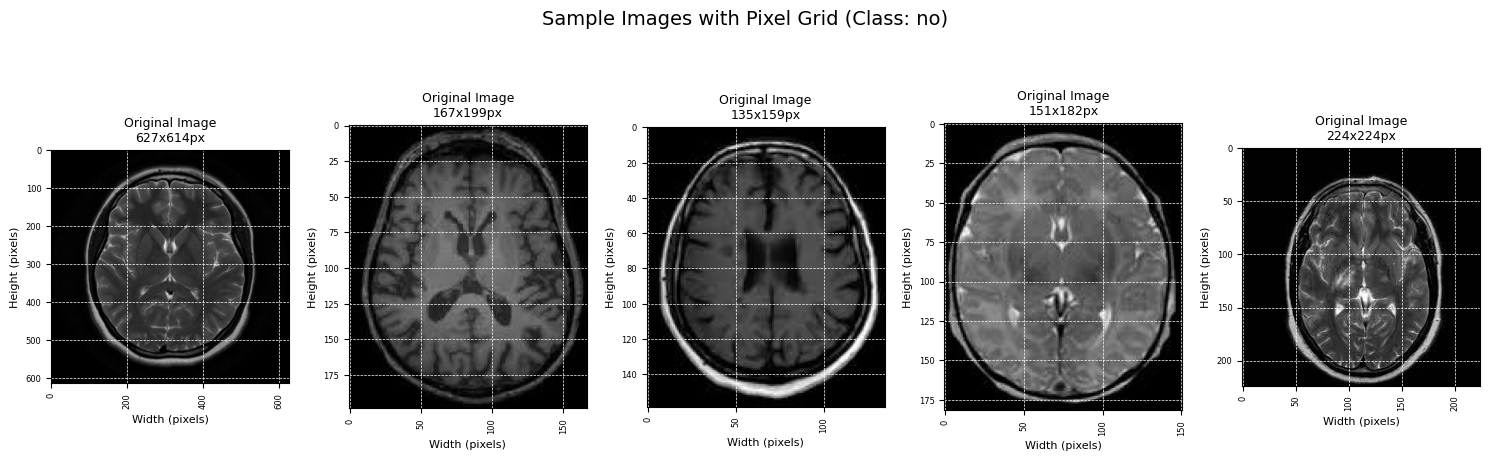

In [ ]:
# Path dataset dari folder yang sudah dikonversi ke RGB
dataset_path = "/content/drive/MyDrive/brain tumor data/tumor_rgb"

# Fungsi untuk menampilkan gambar dengan grid
def display_images_with_pixel_axes_and_label(class_name, num_images=5):
    class_path = os.path.join(dataset_path, class_name)
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:num_images]

    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(img_files):
        img_path = os.path.join(class_path, img_file)
        with Image.open(img_path) as img:
            width, height = img.size
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.grid(True, color='white', linestyle='--', linewidth=0.5)
            plt.xticks(rotation=90, fontsize=6)
            plt.yticks(fontsize=6)
            plt.xlabel("Width (pixels)", fontsize=8)
            plt.ylabel("Height (pixels)", fontsize=8)
            plt.title(f"Original Image\n{width}x{height}px", fontsize=9)

    plt.suptitle(f"Sample Images with Pixel Grid (Class: {class_name})", fontsize=14)
    plt.tight_layout()
    plt.show()

# Menampilkan 5 gambar dari kelas 'yes' dan 'no'
display_images_with_pixel_axes_and_label("yes")
display_images_with_pixel_axes_and_label("no")

In [ ]:
# Path dataset awal dan tujuan
dataset_path = "/content/drive/MyDrive/brain tumor data/tumor_rgb"
resized_dataset_path = "/content/drive/MyDrive/brain tumor data/resized"

# Ukuran target gambar
target_size = (224, 224)

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    save_path = os.path.join(resized_dataset_path, class_name)

    if os.path.isdir(class_path):
        os.makedirs(save_path, exist_ok=True)
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, img_file)
                with Image.open(img_path) as img:
                    img = img.resize(target_size)
                    save_file = os.path.splitext(img_file)[0] + ".jpg"
                    img.save(os.path.join(save_path, save_file))

print("Semua gambar telah diresize ke 224x224 dan disimpan di:", resized_dataset_path)

Semua gambar telah diresize ke 224x224 dan disimpan di: /content/drive/MyDrive/brain tumor data/resized


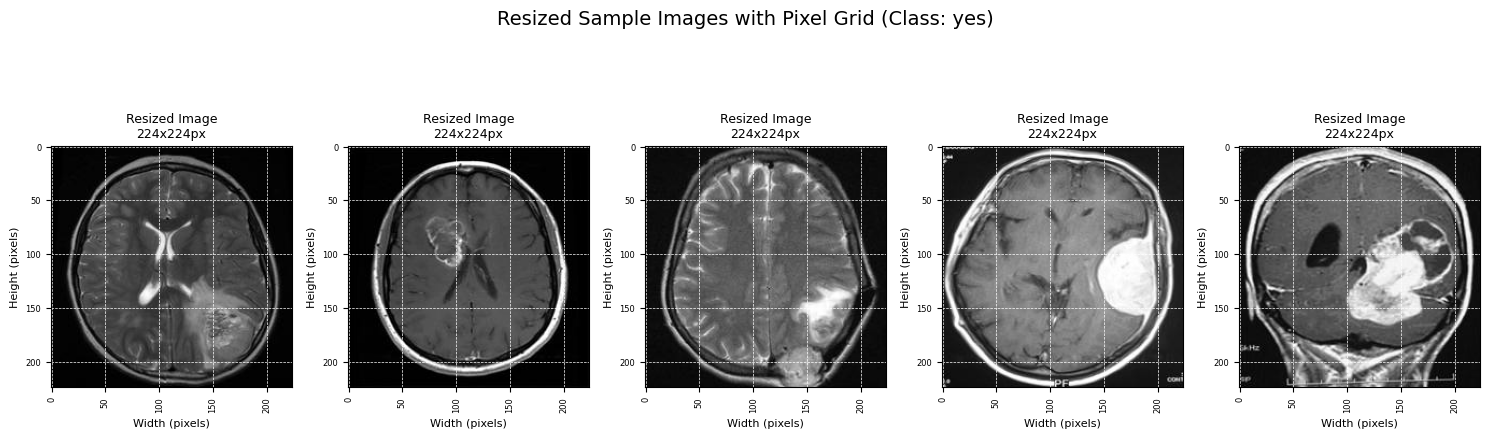

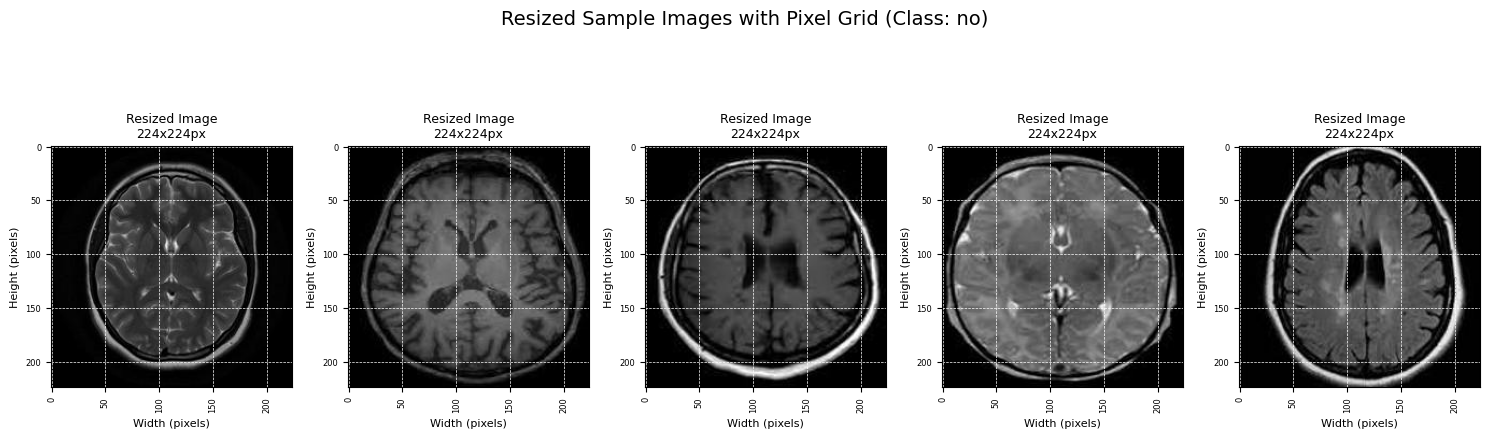

In [ ]:
# Fungsi untuk menampilkan gambar hasil resize dengan grid dan info ukuran
def display_resized_images_with_pixel_axes_and_label(class_name, num_images=5):
    class_path = os.path.join(dataset_path, class_name)
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:num_images]

    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(img_files):
        img_path = os.path.join(class_path, img_file)
        with Image.open(img_path) as img:
            width, height = img.size
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.grid(True, color='white', linestyle='--', linewidth=0.5)
            plt.xticks(rotation=90, fontsize=6)
            plt.yticks(fontsize=6)
            plt.xlabel("Width (pixels)", fontsize=8)
            plt.ylabel("Height (pixels)", fontsize=8)
            plt.title(f"Resized Image\n{width}x{height}px", fontsize=9)

    plt.suptitle(f"Resized Sample Images with Pixel Grid (Class: {class_name})", fontsize=14)
    plt.tight_layout()
    plt.show()

# Tampilkan 5 gambar hasil resize dari kelas 'yes' dan 'no'
display_resized_images_with_pixel_axes_and_label("yes")
display_resized_images_with_pixel_axes_and_label("no")

In [ ]:
def rename_images(dataset_path):
    for class_name in ['no', 'yes']:
        class_path = os.path.join(dataset_path, class_name)
        image_files = sorted(os.listdir(class_path))

        for idx, img_file in enumerate(image_files, start=1):
            ext = os.path.splitext(img_file)[1]
            new_name = f"{class_name}_{idx}{ext}"
            old_path = os.path.join(class_path, img_file)
            new_path = os.path.join(class_path, new_name)

            os.rename(old_path, new_path)
            print(f"Renamed: {img_file} -> {new_name}")

dataset_path = "/content/drive/MyDrive/brain tumor data/resized"
rename_images(dataset_path)
print("Renaming completed!")

Renamed: 1 no_jpeg.jpg -> no_1.jpg
Renamed: 10 no_jpg.jpg -> no_2.jpg
Renamed: 11 no_jpg.jpg -> no_3.jpg
Renamed: 12 no_jpg.jpg -> no_4.jpg
Renamed: 13 no_jpg.jpg -> no_5.jpg
Renamed: 14 no_jpg.jpg -> no_6.jpg
Renamed: 15 no_jpg.jpg -> no_7.jpg
Renamed: 17 no_jpg.jpg -> no_8.jpg
Renamed: 18 no_jpg.jpg -> no_9.jpg
Renamed: 19 no_jpg.jpg -> no_10.jpg
Renamed: 2 no_jpeg.jpg -> no_11.jpg
Renamed: 20 no_jpg.jpg -> no_12.jpg
Renamed: 21 no_jpg.jpg -> no_13.jpg
Renamed: 22 no_jpg.jpg -> no_14.jpg
Renamed: 23 no_jpg.jpg -> no_15.jpg
Renamed: 24 no_jpg.jpg -> no_16.jpg
Renamed: 25 no_jpg.jpg -> no_17.jpg
Renamed: 26 no_jpg.jpg -> no_18.jpg
Renamed: 27 no_jpg.jpg -> no_19.jpg
Renamed: 28 no_jpg.jpg -> no_20.jpg
Renamed: 29 no_jpg.jpg -> no_21.jpg
Renamed: 3 no_jpg.jpg -> no_22.jpg
Renamed: 30 no_jpg.jpg -> no_23.jpg
Renamed: 31 no_jpg.jpg -> no_24.jpg
Renamed: 32 no_jpg.jpg -> no_25.jpg
Renamed: 33 no_jpg.jpg -> no_26.jpg
Renamed: 34 no_jpg.jpg -> no_27.jpg
Renamed: 35 no_jpg.jpg -> no_28.jpg
Re

### Pembagian Dataset

In [ ]:
# Path data
base_path = "/content/drive/MyDrive/brain tumor data/resized"
split_dataset_path = "/content/drive/MyDrive/brain tumor data/resized/split"
class_names = ["no", "yes"]

# Fungsi load data dan label
def load_image_paths_and_labels(base_path):
    image_paths = []
    labels = []
    for cls in class_names:
        cls_dir = os.path.join(base_path, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(cls_dir, fname))
                labels.append(cls)
    return image_paths, labels

# Split stratified dan salin file
def stratified_random_split(image_paths, labels, split_path, train_ratio=0.7):
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths, labels,
        train_size=train_ratio,
        stratify=labels,
        shuffle=True
    )

    splits = {
        "train": (train_paths, train_labels),
        "val": (val_paths, val_labels)
    }

    for split_name, (paths, labels) in splits.items():
        for path, label in zip(paths, labels):
            dst_dir = os.path.join(split_path, split_name, label)
            os.makedirs(dst_dir, exist_ok=True)
            shutil.copy(path, os.path.join(dst_dir, os.path.basename(path)))

    # Menampilkan jumlah gambar per split
    print("Distribusi data:")
    for split_name in ["train", "val"]:
        total = 0
        print(f"\n{split_name.upper()}")
        for cls in class_names:
            cls_path = os.path.join(split_path, split_name, cls)
            count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"  - {cls}: {count}")
            total += count
        print(f"  Total: {total}")

# Menjalankan split
image_paths, labels = load_image_paths_and_labels(base_path)
stratified_random_split(image_paths, labels, split_dataset_path)


Distribusi data:

TRAIN
  - no: 69
  - yes: 108
  Total: 177

VAL
  - no: 29
  - yes: 47
  Total: 76


### Augmentasi

In [ ]:
# Path data
train_path = "/content/drive/MyDrive/brain tumor data/resized/split/train"
target_count_per_class = 253 # Target untuk setiap kelas pada data latih sebanyak 253 masing-masing

def random_augmentation(img):
    ops = []

    # Flip horizontal (50%)
    if random.random() < 0.5:
        img = TF.hflip(img)
        ops.append("flip")

    # Brightness (50% chance)
    if random.random() < 0.5:
       brightness_factor = round(random.uniform(0.8, 1.2), 2)
       img = ImageEnhance.Brightness(img).enhance(brightness_factor)
       ops.append(f"bright{brightness_factor:.2f}")

    # Contrast (50% chance)
    if random.random() < 0.5:
        contrast_factor = round(random.uniform(0.8, 1.2), 2)
        img = ImageEnhance.Contrast(img).enhance(contrast_factor)
        ops.append(f"cont{contrast_factor:.2f}")

    # Rotation ±15 degrees (50%)
    if random.random() < 0.5:
        angle = random.uniform(-20, 20)
        img = img.rotate(angle)
        ops.append(f"rot{angle:+.1f}")

    return img, "_".join(ops)

# Proses augmentasi per kelas
def augment_class(class_dir, current_count, target_count):
    filenames = [f for f in os.listdir(class_dir)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png')) and "_aug" not in f]
    needed = target_count - current_count
    if needed <= 0:
        print(f"Kelas '{os.path.basename(class_dir)}' sudah cukup ({current_count})")
        return

    print(f"Augmentasi {needed} gambar untuk kelas '{os.path.basename(class_dir)}'")
    for i in tqdm(range(needed)):
        src_file = random.choice(filenames)
        src_path = os.path.join(class_dir, src_file)

        with Image.open(src_path) as img:
            aug_img, ops_desc = random_augmentation(img)
            base_name = os.path.splitext(src_file)[0]
            aug_filename = f"{base_name}_aug{i}_{ops_desc}.jpg"
            aug_path = os.path.join(class_dir, aug_filename)
            aug_img.save(aug_path)

for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if not os.path.isdir(class_dir):
        continue

    current_count = len([
        f for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png')) and "_aug" not in f
    ])
    augment_class(class_dir, current_count, target_count_per_class)

print("Augmentasi selesai.")

Augmentasi 184 gambar untuk kelas 'no'


100%|██████████| 184/184 [00:03<00:00, 50.71it/s] 


Augmentasi 145 gambar untuk kelas 'yes'


100%|██████████| 145/145 [00:02<00:00, 51.99it/s] 

Augmentasi selesai.


In [ ]:
import re

def extract_aug_value(filename, aug_type):
    pattern = rf"{aug_type}([+-]?\d+(?:\.\d+)?)"
    match = re.search(pattern, filename)
    return float(match.group(1)) if match else None

def show_extreme_aug_examples(class_dir, aug_types=["bright", "cont", "rot", "flip"]):
    files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    aug_pairs = []

    for aug_type in aug_types:
        aug_candidates = [f for f in files if "_aug" in f and aug_type in f]

        # Filter hanya kandidat yang cukup terlihat flip nya
        if aug_type == "flip":
            chosen = aug_candidates[0] if aug_candidates else None
        elif aug_type == "rot":
            # Filter citra yang rotasinya diatas 10 derajat
            chosen = max(
                [f for f in aug_candidates if abs(extract_aug_value(f, "rot") or 0) >= 10],
                key=lambda x: abs(extract_aug_value(x, "rot") or 0),
                default=None
            )
        else:
            # Filter citra yang brightness atau contrast nya minimal 0.15 dari 1.0
            chosen = max(
                [f for f in aug_candidates if abs((extract_aug_value(f, aug_type) or 1) - 1) >= 0.15],
                key=lambda x: abs((extract_aug_value(x, aug_type) or 1) - 1),
                default=None
            )

        if chosen:
            base_name = chosen.split("_aug")[0] + ".jpg"
            if base_name in files:
                aug_pairs.append((base_name, chosen, aug_type))

    if not aug_pairs:
        print("Tidak ditemukan augmentasi ekstrem yang memenuhi syarat.")
        return

    # Plot hasil
    plt.figure(figsize=(8, 4 * len(aug_pairs)))
    for i, (orig, aug, aug_type) in enumerate(aug_pairs):
        # Original citra
        orig_path = os.path.join(class_dir, orig)
        with Image.open(orig_path) as img:
            plt.subplot(len(aug_pairs), 2, 2*i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Original: {orig}", fontsize=10)

        # Hasil Augmentasi
        aug_path = os.path.join(class_dir, aug)
        with Image.open(aug_path) as img:
            plt.subplot(len(aug_pairs), 2, 2*i + 2)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{aug_type.capitalize()} ➜ {aug}", fontsize=10)

    plt.suptitle("Contoh Augmentasi", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Path data augmentasi
class_dir = "/content/drive/MyDrive/brain tumor data/resized/split/train/yes"
show_extreme_aug_examples(class_dir)

In [ ]:
# Path ke folder split
split_path = "/content/drive/MyDrive/brain tumor data/resized/split"

print("Persebaran data per split dan kelas:")
total_images_all = 0

# Iterasi setiap split: train dan val
for split_name in ["train", "val"]:
    split_dir = os.path.join(split_path, split_name)
    print(f"\nSplit: {split_name.upper()}")
    split_total = 0

    # Iterasi setiap kelas dalam split
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            count = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            print(f"- Kelas '{class_name}': {count} gambar")
            split_total += count

    print(f"  Total gambar di {split_name}: {split_total}")
    total_images_all += split_total

print(f"\nTotal semua gambar: {total_images_all}")

Persebaran data per split dan kelas:

Split: TRAIN
  - Kelas 'no': 253 gambar
  - Kelas 'yes': 253 gambar
  Total gambar di train: 506

Split: VAL
  - Kelas 'no': 29 gambar
  - Kelas 'yes': 47 gambar
  Total gambar di val: 76

Total semua gambar: 582


### Transformasi dan Inisialisasi Dataset

In [ ]:
# Fungsi untuk set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed untuk reproducibility
set_seed(42)

# Transformasi preprocessing (untuk pretrained ImageNet model)
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Path ke direktori dataset yang sudah di-split
data_dir = "/content/drive/MyDrive/brain tumor data/resized/split"

# Load dataset dengan ImageFolder
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transform)
    for x in ['train', 'val']
}

# Generator untuk DataLoader `shuffle=True`
g = torch.Generator()
g.manual_seed(42)

# DataLoader
data_loaders = {
    x: DataLoader(
        image_datasets[x],
        batch_size=32,
        shuffle=(x == 'train'),
        generator=(g if x == 'train' else None),
        num_workers=0,
    )
    for x in ['train', 'val']
}

# Cek dataset
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print("Dataset Sizes:", dataset_sizes)
print("Classes:", class_names)

Dataset Sizes: {'train': 506, 'val': 76}
Classes: ['no', 'yes']


#### Cek nilai hasil normalisasi pretrained imagenet dan gambar di dalam batch size

In [ ]:
# Ambil 1 sample pertama dari dataset
img_path, label = image_datasets['train'].imgs[0]
class_label = class_names[label]

# Load gambar asli
original_image = Image.open(img_path).convert("RGB")

# Konversi ke array numpy sebelum transformasi (nilai 0–255)
np_image = np.array(original_image)

# Transformasi hanya ToTensor (tanpa normalisasi)
tensor_only = transforms.ToTensor()(original_image)

# Transformasi lengkap (ToTensor + Normalize)
transformed_tensor, _ = image_datasets['train'][0]

# Ambil patch tengah 3x3 (Tensor pakai C,H,W → numpy pakai H,W,C)
h, w = tensor_only.shape[1] // 2, tensor_only.shape[2] // 2
start_h, start_w = h - 1, w - 1

patch_np = np_image[start_h:start_h+3, start_w:start_w+3, :]
patch_tensor_only = tensor_only[:, start_h:start_h+3, start_w:start_w+3]
patch_normalized = transformed_tensor[:, start_h:start_h+3, start_w:start_w+3]

# Fungsi untuk cetak array 3x3
def print_array(arr, is_int=False):
    for row in arr:
        if is_int:
            print(" ".join(f"{int(val):>4d}" for val in row))
        else:
            print(" ".join(f"{val:>7.3f}" for val in row))

# Cetak label
print("Label:", class_label)

# Tampilkan posisi global (baris, kolom)
print("Posisi piksel global (baris, kolom):")
for i in range(3):
    for j in range(3):
        global_h = start_h + i
        global_w = start_w + j
        print(f"({global_h:3},{global_w:3})", end=" ")
    print()

# Red Channel
print("Red Channel")
print("Before Tensor (Original Image):")
print_array(patch_np[:, :, 0], is_int=True)
print("After ToTensor (0-1):")
print_array(patch_tensor_only[0].numpy())
print("After Normalization:")
print_array(patch_normalized[0].numpy())

# Green Channel
print("Green Channel")
print("Before Tensor (Original Image):")
print_array(patch_np[:, :, 1], is_int=True)
print("After ToTensor (0-1):")
print_array(patch_tensor_only[1].numpy())
print("After Normalization:")
print_array(patch_normalized[1].numpy())

# Blue Channel
print("Blue Channel")
print("Before Tensor (Original Image):")
print_array(patch_np[:, :, 2], is_int=True)
print("After ToTensor (0-1):")
print_array(patch_tensor_only[2].numpy())
print("After Normalization:")
print_array(patch_normalized[2].numpy())

Label: no
Posisi piksel global (baris, kolom):
(111,111) (111,112) (111,113) 
(112,111) (112,112) (112,113) 
(113,111) (113,112) (113,113) 
Red Channel
Before Tensor (Original Image):
  78   75   58
  77   79   56
  77   75   55
After ToTensor (0-1):
  0.306   0.294   0.227
  0.302   0.310   0.220
  0.302   0.294   0.216
After Normalization:
 -0.782  -0.834  -1.125
 -0.799  -0.765  -1.159
 -0.799  -0.834  -1.176
Green Channel
Before Tensor (Original Image):
  78   75   58
  77   79   56
  77   75   55
After ToTensor (0-1):
  0.306   0.294   0.227
  0.302   0.310   0.220
  0.302   0.294   0.216
After Normalization:
 -0.670  -0.723  -1.020
 -0.688  -0.653  -1.055
 -0.688  -0.723  -1.073
Blue Channel
Before Tensor (Original Image):
  78   75   58
  77   79   56
  77   75   55
After ToTensor (0-1):
  0.306   0.294   0.227
  0.302   0.310   0.220
  0.302   0.294   0.216
After Normalization:
 -0.445  -0.497  -0.794
 -0.462  -0.428  -0.828
 -0.462  -0.497  -0.846


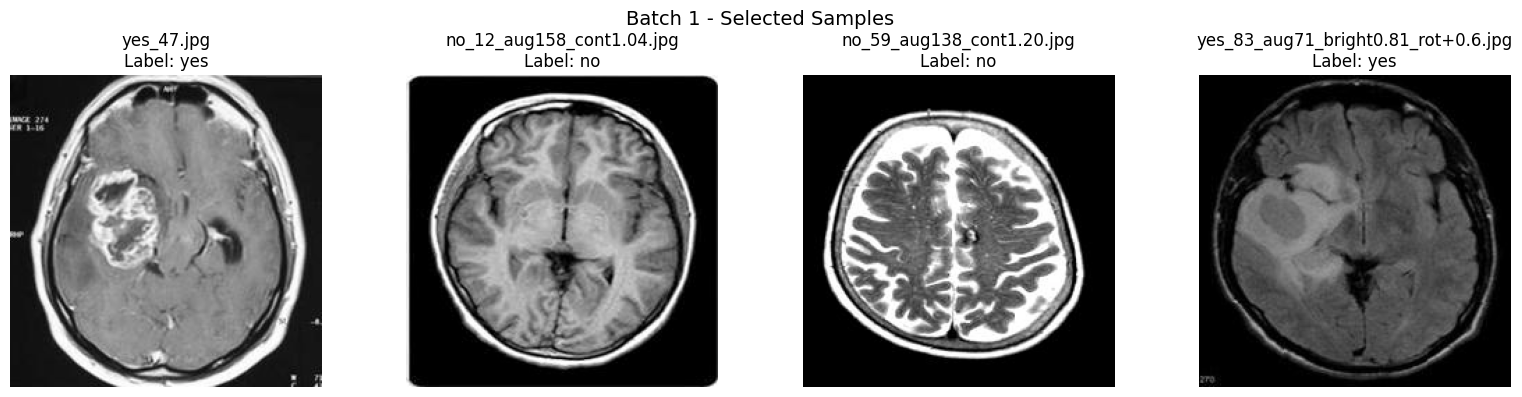

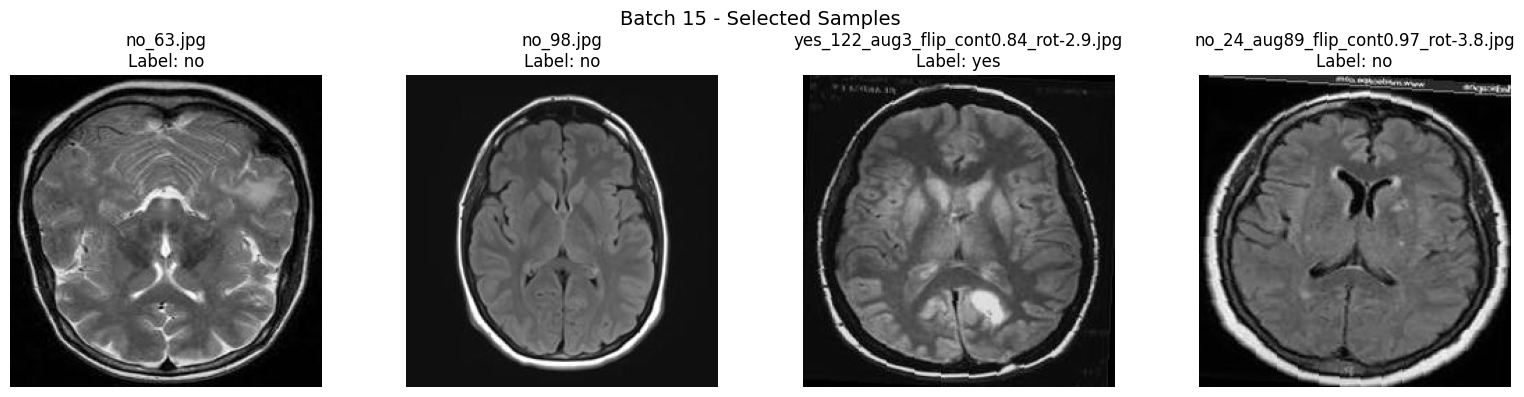

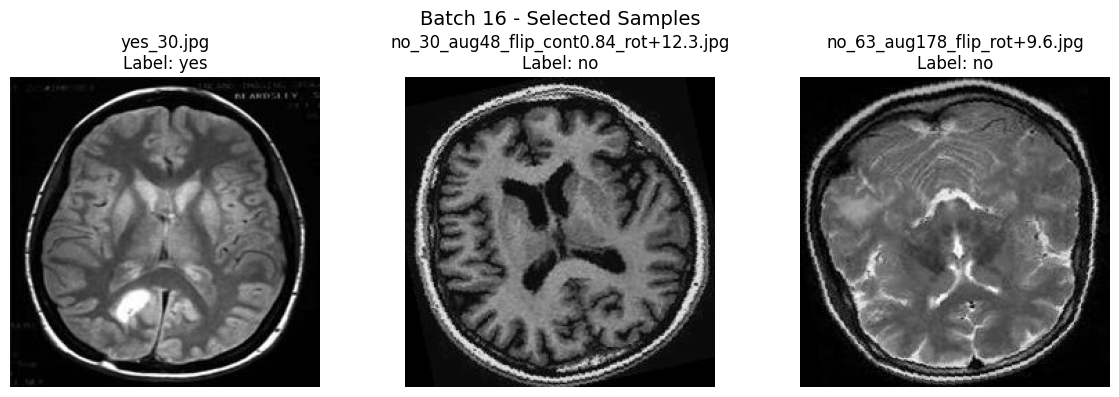

In [ ]:
# Unnormalize untuk visualisasi gambar lebih jelas
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img_tensor * std + mean
    return torch.clamp(img, 0, 1)

# Mendapatkan urutan indeks semua gambar di train set
indices = list(data_loaders['train'].sampler)
all_paths = [image_datasets['train'].imgs[i][0] for i in indices]

# Fungsi untuk ambil gambar pada batch ke-n dan sample ke-i
def show_selected_samples(batch_number, sample_indices):
    batch_size = 32
    start_idx = (batch_number - 1) * batch_size
    selected_paths = []
    selected_imgs = []

    for sample_idx in sample_indices:
        absolute_idx = start_idx + (sample_idx - 1)
        if absolute_idx >= len(indices):
            print(f"Batch {batch_number}, sample {sample_idx} out of range (dataset size: {len(indices)}).")
            continue
        path = all_paths[absolute_idx]
        img, label = image_datasets['train'][indices[absolute_idx]]
        selected_paths.append((path, label))
        selected_imgs.append(unnormalize(img))

    # Menampilkan gambar dan path-nya
    plt.figure(figsize=(4 * len(selected_imgs), 4))
    for i, img in enumerate(selected_imgs):
        plt.subplot(1, len(selected_imgs), i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"{os.path.basename(selected_paths[i][0])}\nLabel: {class_names[selected_paths[i][1]]}")
        plt.axis("off")
    plt.suptitle(f"Batch {batch_number} - Selected Samples", fontsize=14)
    plt.tight_layout()
    plt.show()

# 1. Batch 1, sample 1, 2, 26, 32
show_selected_samples(1, [1, 2, 26, 32])

# 2. Batch 2, sample 1, 2, 26, 32
show_selected_samples(2, [1, 2, 26, 32])

# 3. Batch 15, sample 1, 2, 26, 32
show_selected_samples(15, [1, 2, 26, 32])

# 4. Batch 16, sample 1, 2, 26 (total 506 data latih -> batch 16 -> 506 - 480 = 26 data (pada batch terakhir))
show_selected_samples(16, [1, 2, 26])

## Perancangan Arsitektur Model

In [ ]:
# Load model ResNet-50 dengan bobot V1
model_resnet = models.resnet50(pretrained=True)

# Freeze semua parameter di backbone model ResNet50
for param in model_resnet.parameters():
    param.requires_grad = False

# Lapisan klasifikasi terakhir (fc) menjadi 1 neuron output
num_ftrs = model_resnet.fc.in_features
output_neurons = 1 # Hanya 1 neuron output untuk BCEWithLogitsLoss
model_resnet.fc = nn.Linear(num_ftrs, output_neurons)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 102MB/s]


In [ ]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Hitung jumlah parameter
total_params = sum(p.numel() for p in model_resnet.parameters())
trainable_params = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Non-trainable Parameters: {non_trainable_params}")

Total Parameters: 23510081
Trainable Parameters: 2049
Non-trainable Parameters: 23508032


### Fungsi training, evaluasi dan plot

In [ ]:
# Fungsi Training Model dengan Time Tracking
def train_model(model, criterion, optimizer, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss, running_corrects = 0.0, 0

            for inputs, labels in data_loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.view(-1, 1)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.float())

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                preds = (torch.sigmoid(outputs) > 0.5).float()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")

    model.load_state_dict(best_model_wts)
    return model, history

# Evaluasi Akhir
def evaluate_model(model, phase="val"):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in data_loaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("Final Evaluation - Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({phase.capitalize()} Set)")
    plt.show()

# Visualisasi Riwayat Pelatihan
def plot_training_history(history, title="Training Performance", sigma=1):
    from scipy.ndimage import gaussian_filter1d
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(14, 6))

    # Smoothing
    train_loss_smooth = gaussian_filter1d(history["train_loss"], sigma=sigma)
    val_loss_smooth = gaussian_filter1d(history["val_loss"], sigma=sigma)
    train_acc_smooth = gaussian_filter1d(history["train_acc"], sigma=sigma)
    val_acc_smooth = gaussian_filter1d(history["val_acc"], sigma=sigma)

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_smooth, label="Train Loss", color="blue")
    plt.plot(epochs, val_loss_smooth, label="Val Loss", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_smooth, label="Train Accuracy", color="green")
    plt.plot(epochs, val_acc_smooth, label="Val Accuracy", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.grid(True)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_pso_optimization(val_metrics, n_particles, title="PSO Optimization Progress", metric_name="Validation Loss"):
    best_vals = []
    num_iters = len(val_metrics) // n_particles

    for i in range(num_iters):
        iter_vals = val_metrics[i * n_particles : (i + 1) * n_particles]
        best_vals.append(min(iter_vals))

    iterations = list(range(num_iters))  # Mulai dari 0
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, best_vals, marker='o', color='purple', linewidth=2)

    best_idx = int(np.argmin(best_vals))
    best_val = best_vals[best_idx]
    plt.scatter(iterations[best_idx], best_val, color='red',
                label=f"Best: {best_val:.4f} at Iter {iterations[best_idx]}")

    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel(metric_name)
    plt.xticks(iterations)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Model Transfer Learning CNN-ResNet 50 tanpa PSO

In [ ]:
class SuppressPrint:
    def __enter__(self):
        self._original_print = builtins.print
        builtins.print = lambda *args, **kwargs: None

    def __exit__(self, exc_type, exc_val, exc_tb):
        builtins.print = self._original_print

# Kombinasi manual 12 kombinasi
lr_list = [0.0001, 0.0003, 0.0005]
epoch_list = [4, 8, 12, 15]
combinations = list(itertools.product(lr_list, epoch_list))[:12]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []

# Fungsi training model
def run_baseline_model(lr, epochs, show_log=False):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 1)
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=lr)

    if not show_log:
        with SuppressPrint():
            model, history = train_model(model, criterion, optimizer, num_epochs=epochs)
    else:
        model, history = train_model(model, criterion, optimizer, num_epochs=epochs)

    # Ambil val loss terakhir
    val_loss = history['val_loss'][-1]
    val_acc = history['val_acc'][-1]

    return model, val_loss, val_acc, history

for i, (lr, epochs) in enumerate(combinations):
    model, val_loss, val_acc, history = run_baseline_model(lr, epochs)
    print(f"[{i+1:02}] LR: {lr:<7} Epochs: {epochs:<2} --> Val Loss: {val_loss:.4f}")

    results.append({
        'combo': (lr, epochs),
        'val_loss': val_loss,
        'val_acc': val_acc,
        'model': model,
        'history': history
    })

# Kombinasi terbaik berdasarkan val loss terendah
best_result = min(results, key=lambda x: x['val_loss'])
best_lr, best_epochs = best_result['combo']
print(f"\nBest Baseline Kombinasi: LR={best_lr}, Epochs={best_epochs}, Val Loss={best_result['val_loss']:.4f}")

[01] LR: 0.0001  Epochs: 4  --> Val Loss: 0.6509
[02] LR: 0.0001  Epochs: 8  --> Val Loss: 0.5623
[03] LR: 0.0001  Epochs: 12 --> Val Loss: 0.5042
[04] LR: 0.0001  Epochs: 15 --> Val Loss: 0.5052
[05] LR: 0.0003  Epochs: 4  --> Val Loss: 0.5117
[06] LR: 0.0003  Epochs: 8  --> Val Loss: 0.4179
[07] LR: 0.0003  Epochs: 12 --> Val Loss: 0.3989
[08] LR: 0.0003  Epochs: 15 --> Val Loss: 0.3633
[09] LR: 0.0005  Epochs: 4  --> Val Loss: 0.4651
[10] LR: 0.0005  Epochs: 8  --> Val Loss: 0.3813
[11] LR: 0.0005  Epochs: 12 --> Val Loss: 0.3748
[12] LR: 0.0005  Epochs: 15 --> Val Loss: 0.3500

Best Baseline Kombinasi: LR=0.0005, Epochs=15, Val Loss=0.3500


Epoch 1/15
Train Loss: 0.6815 Acc: 0.5553
Val Loss: 0.6011 Acc: 0.7105
Epoch 2/15
Train Loss: 0.5951 Acc: 0.7628
Val Loss: 0.5490 Acc: 0.8684
Epoch 3/15
Train Loss: 0.5397 Acc: 0.8103
Val Loss: 0.5197 Acc: 0.8553
Epoch 4/15
Train Loss: 0.5044 Acc: 0.8241
Val Loss: 0.4988 Acc: 0.8421
Epoch 5/15
Train Loss: 0.4755 Acc: 0.8379
Val Loss: 0.4615 Acc: 0.8684
Epoch 6/15
Train Loss: 0.4506 Acc: 0.8300
Val Loss: 0.4603 Acc: 0.8289
Epoch 7/15
Train Loss: 0.4359 Acc: 0.8360
Val Loss: 0.3966 Acc: 0.9079
Epoch 8/15
Train Loss: 0.4252 Acc: 0.8221
Val Loss: 0.4521 Acc: 0.8158
Epoch 9/15
Train Loss: 0.4111 Acc: 0.8557
Val Loss: 0.3963 Acc: 0.8947
Epoch 10/15
Train Loss: 0.3719 Acc: 0.8656
Val Loss: 0.3758 Acc: 0.8816
Epoch 11/15
Train Loss: 0.3721 Acc: 0.8794
Val Loss: 0.3756 Acc: 0.8947
Epoch 12/15
Train Loss: 0.3491 Acc: 0.8913
Val Loss: 0.3486 Acc: 0.9079
Epoch 13/15
Train Loss: 0.3522 Acc: 0.8834
Val Loss: 0.3431 Acc: 0.9079
Epoch 14/15
Train Loss: 0.3517 Acc: 0.8656
Val Loss: 0.3294 Acc: 0.9211
E

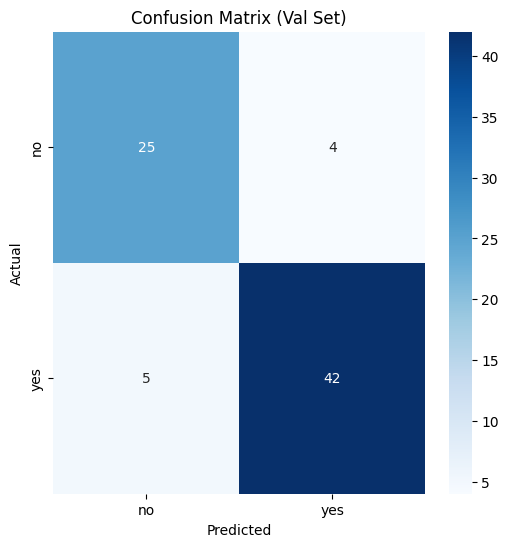

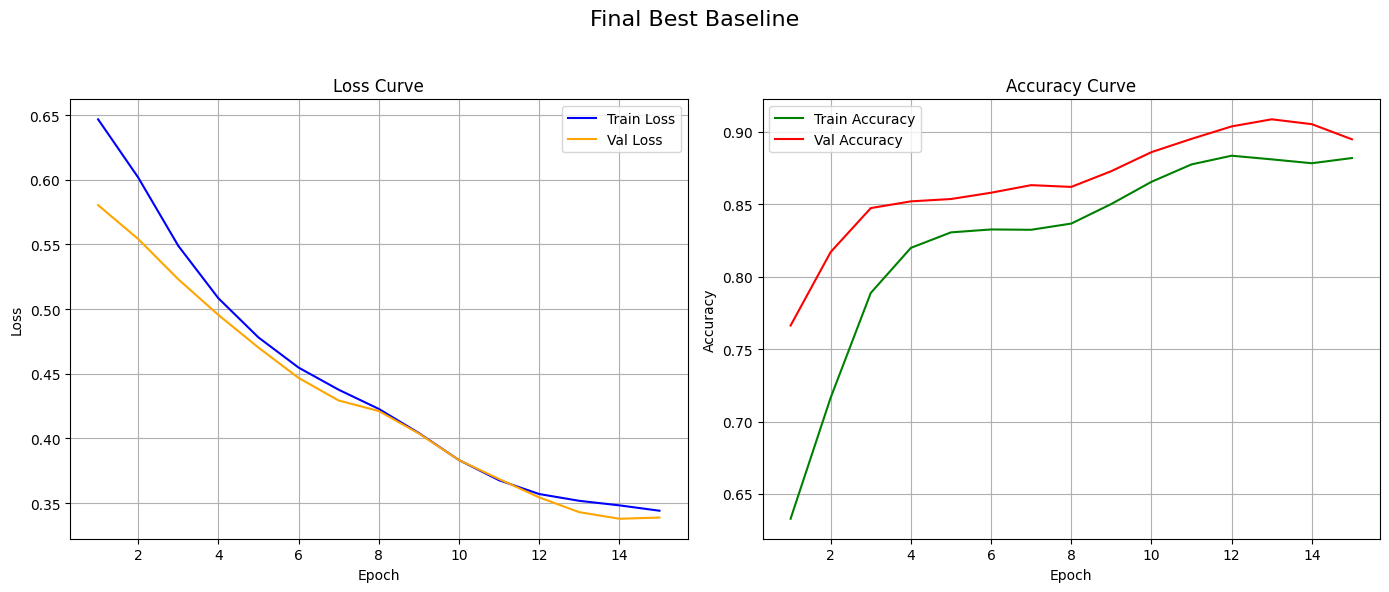

In [ ]:
# Retrain final model dengan kombinasi terbaik
final_model, _, _, final_history = run_baseline_model(best_lr, best_epochs, show_log=True)

# Evaluasi & Plot
evaluate_model(final_model, phase="val")
plot_training_history(final_history, title="Final Best Baseline")

In [ ]:
torch.save(best_result['model'].state_dict(), "resnet50_best_weights_kombinasi.pth")

### Model Transfer Learning CNN-ResNet 50 dengan mencari hyperparameter learning terbaik menggunakan PSO

#### Optimasi Hyperparameter Learning CNN-ResNet 50 dengan PSO


[INISIALISASI - PARTIKEL A] Evaluasi Learning Rate: 0.003808, Epochs: 14
   Epoch 1/14 ... Validation Loss: 0.5052
   Epoch 2/14 ... Validation Loss: 0.5019
   Epoch 3/14 ... Validation Loss: 0.4029
   Epoch 4/14 ... Validation Loss: 0.4004
   Epoch 5/14 ... Validation Loss: 0.2925
   Epoch 6/14 ... Validation Loss: 0.2799
   Epoch 7/14 ... Validation Loss: 0.2772
   Epoch 8/14 ... Validation Loss: 0.2681
   Epoch 9/14 ... Validation Loss: 0.2655
   Epoch 10/14 ... Validation Loss: 0.2675
   Epoch 11/14 ... Validation Loss: 0.3080
   Epoch 12/14 ... Validation Loss: 0.2649
   Epoch 13/14 ... Validation Loss: 0.2601
   Epoch 14/14 ... Validation Loss: 0.2519
[INISIALISASI - PARTIKEL A] Selesai dalam 35.48 detik. Val Loss Terakhir: 0.2519


[INISIALISASI - PARTIKEL B] Evaluasi Learning Rate: 0.007347, Epochs: 9
   Epoch 1/9 ... Validation Loss: 0.3759
   Epoch 2/9 ... Validation Loss: 0.3140
   Epoch 3/9 ... Validation Loss: 0.3491
   Epoch 4/9 ... Validation Loss: 0.3564
   Epoch 5/9 .

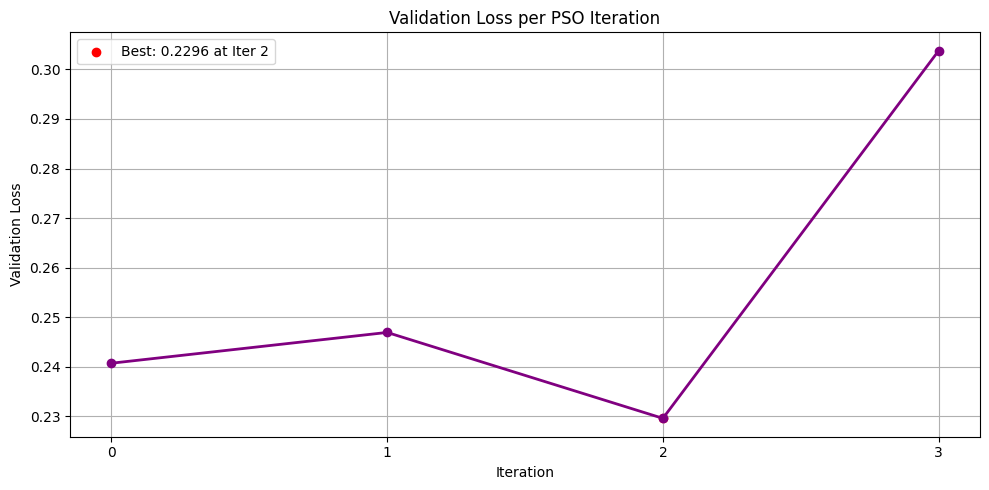

In [ ]:
pso_result_dict = {}
global_call_count = {"count": 0}
val_loss_history = []  # log untuk loss per iterasi

swarmsize = 3

def objective_function(params):
    lr, num_epochs = params
    num_epochs = int(num_epochs)

    # Memberikan log sedang inisialisasi atau iterasi
    call = global_call_count["count"]
    particle_idx = call % swarmsize
    iter_num = call // swarmsize
    particle_label = string.ascii_uppercase[particle_idx]

    if iter_num == 0:
        log_prefix = f"[INISIALISASI - PARTIKEL {particle_label}]"
    else:
        log_prefix = f"[ITERASI {iter_num} - PARTIKEL {particle_label}]"

    print(f"\n{log_prefix} Evaluasi Learning Rate: {lr:.6f}, Epochs: {num_epochs}")

    # Setup model
    model_resnet_pso = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    for param in model_resnet_pso.parameters():
        param.requires_grad = False
    num_ftrs = model_resnet_pso.fc.in_features
    model_resnet_pso.fc = nn.Linear(num_ftrs, 1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_resnet_pso = model_resnet_pso.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model_resnet_pso.fc.parameters(), lr=lr)

    start_time = time.time()

    # Training
    for epoch in range(num_epochs):
        model_resnet_pso.train()
        for inputs, labels in data_loaders['train']:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model_resnet_pso(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        val_loss = 0.0
        model_resnet_pso.eval()
        with torch.no_grad():
            for inputs, labels in data_loaders['val']:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model_resnet_pso(inputs).squeeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= dataset_sizes['val']
        print(f"   Epoch {epoch+1}/{num_epochs} ... Validation Loss: {val_loss:.4f}")

    elapsed_time = time.time() - start_time
    print(f"{log_prefix} Selesai dalam {elapsed_time:.2f} detik. Val Loss Terakhir: {val_loss:.4f}\n")

    # Menyimpan Hasil
    label = f"{log_prefix} | LR: {lr:.6f} | Epochs: {num_epochs}"
    pso_result_dict[label] = val_loss
    val_loss_history.append(val_loss)  # log val loss

    global_call_count["count"] += 1
    return val_loss

# Batas bawah dan atas hyperparameter PSO
lb = [0.0001, 1]
ub = [0.01, 15]

# Konfigurasi PSO (parameter pso)
best_params, _ = pso(objective_function, lb, ub, swarmsize=swarmsize, maxiter=3, omega=0.8, phip=1.0, phig=1.2)

# Plot hasil tracking loss per iterasi
plot_pso_optimization(val_loss_history, n_particles=3,
                      title="Validation Loss per PSO Iteration",
                      metric_name="Validation Loss")

In [ ]:
print("\n=== Ringkasan Hasil PSO ===")
sorted_results = sorted(pso_result_dict.items(), key=lambda x: x[1])
for partikel, loss in sorted_results:
    print(f"{partikel} --> Final Val Loss: {loss:.4f}")

best_partikel = sorted_results[0]
print(f"\n>> Partikel terbaik: {best_partikel[0]} dengan Val Loss: {best_partikel[1]:.4f}")


=== Ringkasan Hasil PSO ===
[ITERASI 2 - PARTIKEL C] | LR: 0.004936 | Epochs: 15 --> Final Val Loss: 0.2296
[INISIALISASI - PARTIKEL B] | LR: 0.007347 | Epochs: 9 --> Final Val Loss: 0.2407
[ITERASI 1 - PARTIKEL B] | LR: 0.008948 | Epochs: 14 --> Final Val Loss: 0.2469
[INISIALISASI - PARTIKEL A] | LR: 0.003808 | Epochs: 14 --> Final Val Loss: 0.2519
[ITERASI 2 - PARTIKEL A] | LR: 0.002942 | Epochs: 15 --> Final Val Loss: 0.2817
[ITERASI 3 - PARTIKEL A] | LR: 0.005561 | Epochs: 15 --> Final Val Loss: 0.3038
[ITERASI 2 - PARTIKEL B] | LR: 0.009785 | Epochs: 10 --> Final Val Loss: 0.3743
[INISIALISASI - PARTIKEL C] | LR: 0.001645 | Epochs: 3 --> Final Val Loss: 0.3789
[ITERASI 1 - PARTIKEL C] | LR: 0.000100 | Epochs: 15 --> Final Val Loss: 0.4813
[ITERASI 1 - PARTIKEL A] | LR: 0.000100 | Epochs: 15 --> Final Val Loss: 0.5088
[ITERASI 3 - PARTIKEL B] | LR: 0.007280 | Epochs: 10 --> Final Val Loss: 0.5107
[ITERASI 3 - PARTIKEL C] | LR: 0.008805 | Epochs: 15 --> Final Val Loss: 0.5187

>> 

In [ ]:
import re

# Menemukan kombinasi dengan val_loss terkecil
best_params_label, final_val_loss = min(pso_result_dict.items(), key=lambda x: x[1])

# Ekstrak nilai LR dan epoch dari string label
match = re.search(r"LR: ([0-9.]+) \| Epochs: (\d+)", best_params_label)
best_lr = float(match.group(1))
best_num_epochs = int(match.group(2))

# Cetak kombinasi hyperparameter terbaik secara jelas
print("==========================================")
print("===== KOMBINASI HYPERPARAMETER TERBAIK ====")
print(f"Learning Rate Terbaik     : {best_lr:.6f}")
print(f"Jumlah Epoch (dari PSO)   : {best_num_epochs}")
print(f"Validation Loss Terakhir  : {final_val_loss:.4f}")
print(f"==> Kombinasi terbaik: LR {best_lr:.6f} @ Epoch {best_num_epochs}")
print("==========================================")


===== KOMBINASI HYPERPARAMETER TERBAIK ====
Learning Rate Terbaik     : 0.004936
Jumlah Epoch (dari PSO)   : 15
Validation Loss Terakhir  : 0.2296
==> Kombinasi terbaik: LR 0.004936 @ Epoch 15



#### Model transfer learning CNN-ResNet 50 dengan hyperparameter learning terbaik

Epoch 1/15
Train Loss: 0.8548 Acc: 0.5435
Val Loss: 0.6877 Acc: 0.5526
Epoch 2/15
Train Loss: 0.4721 Acc: 0.7530
Val Loss: 0.3978 Acc: 0.8026
Epoch 3/15
Train Loss: 0.3740 Acc: 0.8498
Val Loss: 0.3131 Acc: 0.9079
Epoch 4/15
Train Loss: 0.3123 Acc: 0.8953
Val Loss: 0.3553 Acc: 0.8684
Epoch 5/15
Train Loss: 0.3360 Acc: 0.8617
Val Loss: 0.3154 Acc: 0.8684
Epoch 6/15
Train Loss: 0.2791 Acc: 0.8834
Val Loss: 0.3211 Acc: 0.8816
Epoch 7/15
Train Loss: 0.2375 Acc: 0.9150
Val Loss: 0.2605 Acc: 0.9211
Epoch 8/15
Train Loss: 0.2413 Acc: 0.9130
Val Loss: 0.2810 Acc: 0.9342
Epoch 9/15
Train Loss: 0.3093 Acc: 0.8458
Val Loss: 0.2929 Acc: 0.8947
Epoch 10/15
Train Loss: 0.2263 Acc: 0.9130
Val Loss: 0.2505 Acc: 0.9474
Epoch 11/15
Train Loss: 0.1940 Acc: 0.9368
Val Loss: 0.2462 Acc: 0.9474
Epoch 12/15
Train Loss: 0.1752 Acc: 0.9447
Val Loss: 0.2486 Acc: 0.9342
Epoch 13/15
Train Loss: 0.1768 Acc: 0.9526
Val Loss: 0.2507 Acc: 0.9342
Epoch 14/15
Train Loss: 0.1601 Acc: 0.9625
Val Loss: 0.2580 Acc: 0.9079
E

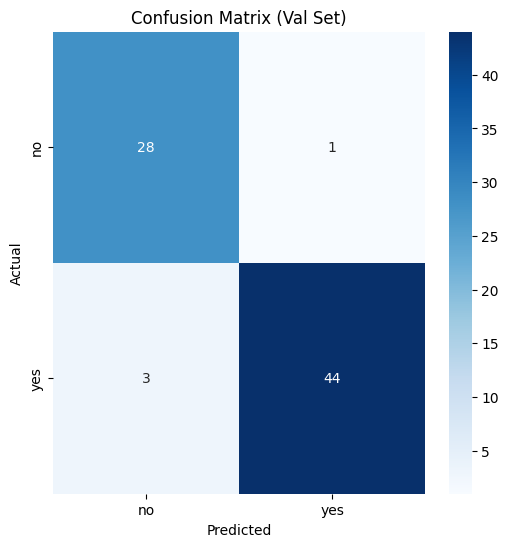

In [ ]:
# FINAL TRAINING
# Load model ResNet-50 pretrained ImageNet
model_resnet_pso = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in model_resnet_pso.parameters():
    param.requires_grad = False

model_resnet_pso.fc = nn.Linear(model_resnet_pso.fc.in_features, 1)
criterion = nn.BCEWithLogitsLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet_pso = model_resnet_pso.to(device)

optimizer = optim.Adam(model_resnet_pso.fc.parameters(), lr=best_lr)

start_time = time.time()

# Retrain model
model_resnet_pso, history_pso = train_model(model_resnet_pso, criterion, optimizer, num_epochs=best_num_epochs)

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

# Evaluasi model
evaluate_model(model_resnet_pso, phase="val")
plot_training_history(history_pso, title="ResNet-50 with PSO")

In [ ]:
torch.save(model_resnet_pso.state_dict(), "resnet50_pso_weights.pth")